# **05**

In [1]:
import pandas as pd

In [2]:
def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                columns=['dup_cnt'])

  feature_dup_df = feature_dup_df.reset_index()
  new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                      if x[1]>0 else x[0], axis=1)

  new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
  return new_feature_name_df

In [3]:
import pandas as pd

def get_human_dataset():
  feature_name_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/UCI HAR Dataset/features.txt', sep='\s+',
                             header=None, names=['column_index', 'column_name'])

  # 중복된 피처명 수정하는 get_new_feature_name 이용, 신규 피처명의 DataFrame 생성
  new_feature_name_df = get_new_feature_name_df(feature_name_df)

  # DataFrame에 피처명을 칼럼으로 부여하기 위해, 리스트로 변환
  feature_name = new_feature_name_df.iloc[:,1].values.tolist()

  # 학습/테스트 피처 데이터세트를 DataFrame으로 로딩, 칼럼명 feature_name
  X_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/UCI HAR Dataset/train/X_train.txt',
                        sep='\s+', header = None, names=feature_name)
  X_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/UCI HAR Dataset/test/X_test.txt',
                       sep='\s+', header = None, names=feature_name)

  # 학습/테스트 피처 데이터세트를 DataFrame으로 로딩, 칼럼명 action
  y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/UCI HAR Dataset/train/y_train.txt',
                        sep='\s+', header = None, names=['action'])
  y_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/UCI HAR Dataset/test/y_test.txt',
                       sep='\s+', header = None, names=['action'])

  # 로드된 DataFrame 모두 반환
  return X_train, X_test, y_train, y_test

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time
import warnings

warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정, 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM accuracy: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.4f} sec'.format(time.time() - start_time))



GBM accuracy: 0.9386
GBM 수행 시간: 1040.9682 sec


In [ ]:
from sklearn.model_selection import GridSearchCV
# best_params_ : learning_rate=0.05, n_estimator=500

params = {
    'n_estimators': [100, 500],
    'learning_rate': [0.05, 0.1]
}

grid_cv = GridSearchCV(gb_clf, param_grid = params, cv=2, verbose = 1)
grid_cv.fit(X_train, y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


In [ ]:
# GridSearchCV을 이용해 최적으로 학습된 estimator로 학습 수행
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy= accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

# >>정확도 0.9410

# **06**

In [6]:
import xgboost as xgb
print(xgb.__version__)


from xgboost import XGBClassifier


1.7.6


In [7]:
# 위스콘신 유방암 예측

import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [8]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [9]:
# 학습용 데이터 80, 테스트 데이터 20

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                    test_size=0.2, random_state=156)
print(X_train.shape, y_test.shape)

(455, 30) (114,)


In [10]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [11]:
params ={
    'max_depth':3,
    'eta':0.1,
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    'early_stoppings':100
    }

num_rounds = 400


In [12]:
# train > train, evaluation(test) > eval 명기
wlist = [(dtrain, 'train'),(dtest, 'eval')]

#하이퍼 params, early stopping params(wlist) 트레인으로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds,\
                      early_stopping_rounds=100, evals=wlist)

[23:14:19] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoppings" } are not used.

[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35415	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0.23156
[13]	train-logloss:0.17792	eval-logloss:0.22005
[14]	train-logloss:0.16522	eval-logloss:0.20857
[15]	train-logloss:0.15362	eval-logloss:0.19999
[16]	train-logloss:0.14333	eval-logloss:0.19012
[17]	train-logloss:0.13398	eval-logloss:0.18182
[18]	train-logloss:0.12560	eval-logloss:0.17473
[19]	

In [13]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값(예측 확률)')
print(np.round(pred_probs[:10], 3))

# 확률 0.5보다 크면 1 아니면 0 > 리스트 preds 저장
preds = [1 if x>0.5 else 0 for x in pred_probs]
print('predictions:', preds[:10])

predict() 수행 결과값(예측 확률)
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
predictions: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [14]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score


def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix( y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)

  f1 = f1_score(y_test, pred)

  # ROC_AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)

  print('오차행렬')
  print(confusion)

  # ROC-AUC print 추가

  print('accuracy: {0:.4f}, precision:{1:.4f}, recall: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'
        .format(accuracy, precision, recall,f1,roc_auc))

In [15]:
get_clf_eval(y_test, preds, pred_probs)

오차행렬
[[35  2]
 [ 1 76]]
accuracy: 0.9737, precision:0.9744, recall: 0.9870, F1: 0.9806, AUC: 0.9951


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

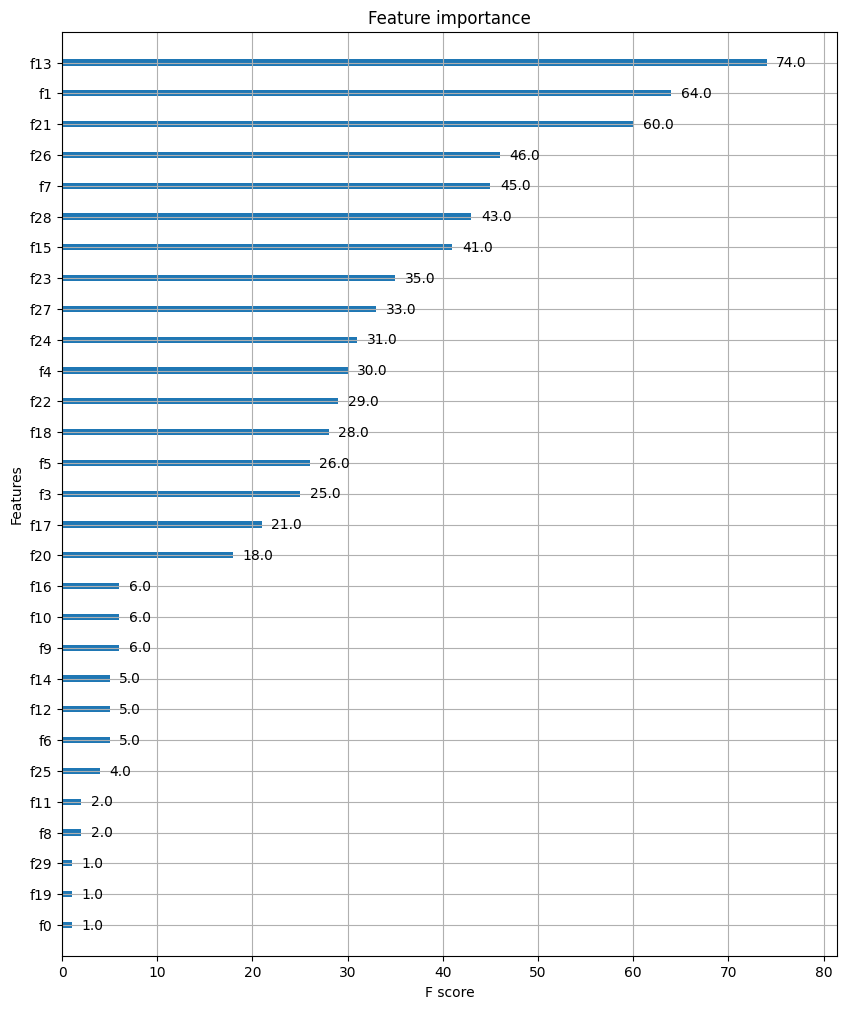

In [16]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

In [17]:
# import sklearn Wrapper class : XGBClassifier
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimator=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, w_preds, w_pred_proba)

[23:14:39] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

오차행렬
[[34  3]
 [ 2 75]]
accuracy: 0.9561, precision:0.9615, recall: 0.9740, F1: 0.9677, AUC: 0.9947


In [18]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimator=400, learning_rate=0.1, max_depth=3)

evals=[(X_test, y_test)]

xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
                eval_set=evals, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]


[23:14:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27

In [19]:

get_clf_eval(y_test, w_preds, w_pred_proba)

오차행렬
[[34  3]
 [ 2 75]]
accuracy: 0.9561, precision:0.9615, recall: 0.9740, F1: 0.9677, AUC: 0.9947


In [20]:
# early_stopping_rounds =10
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss",
                eval_set=evals, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, w_preds, w_pred_proba)

[23:14:48] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

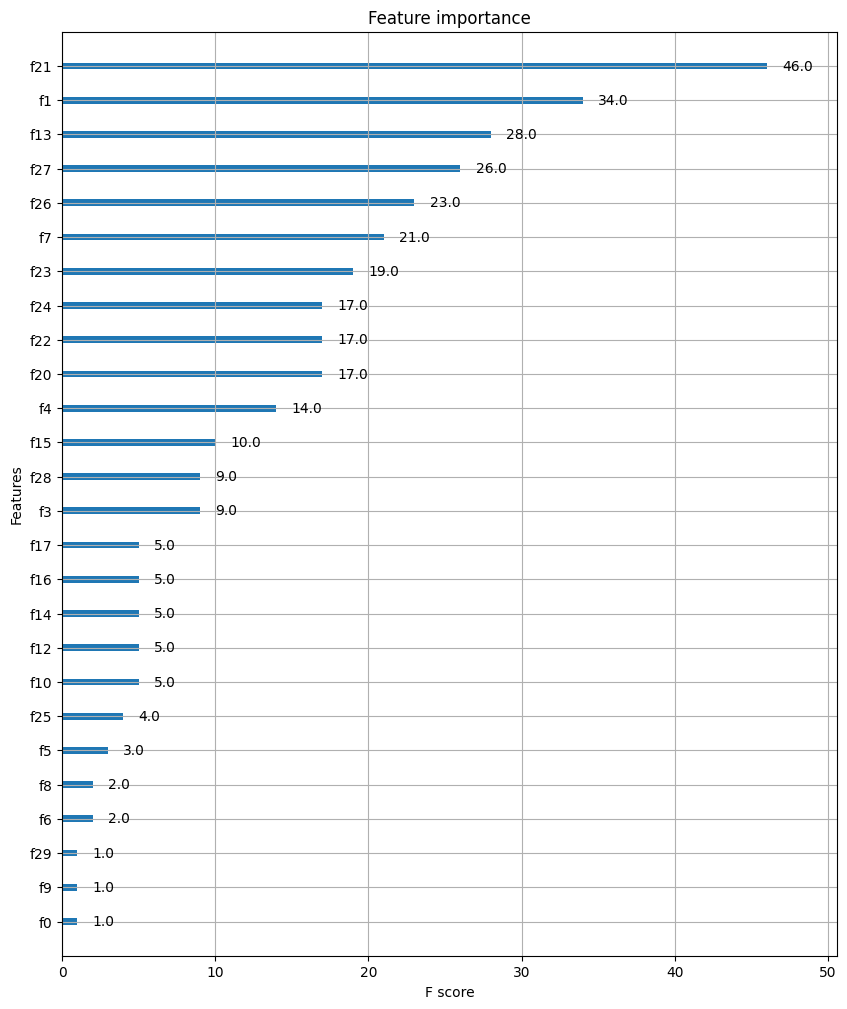

In [21]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
# 사이킷런 Wrapper클래스 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

# **07**

In [25]:
from lightgbm import LGBMClassifier

import pandas as pd

import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

lgbm_wrapper = LGBMClassifier(n_estimator = 400)

evals = [(X_test, y_test)]
#lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
#                 eval_set=evals, verbose=True)
lgbm_wrapper.fit(X_train, y_train)
preds=lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

# 왜 아규먼트가 없다고 뜰까요
# early_stopping_rounds, verbose > unexpected keyword


[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Info] Number of positive: 280, number of negative: 175
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4542
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [26]:
get_clf_eval(y_test, preds, pred_proba)

오차행렬
[[33  4]
 [ 1 76]]
accuracy: 0.9561, precision:0.9500, recall: 0.9870, F1: 0.9682, AUC: 0.9926


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

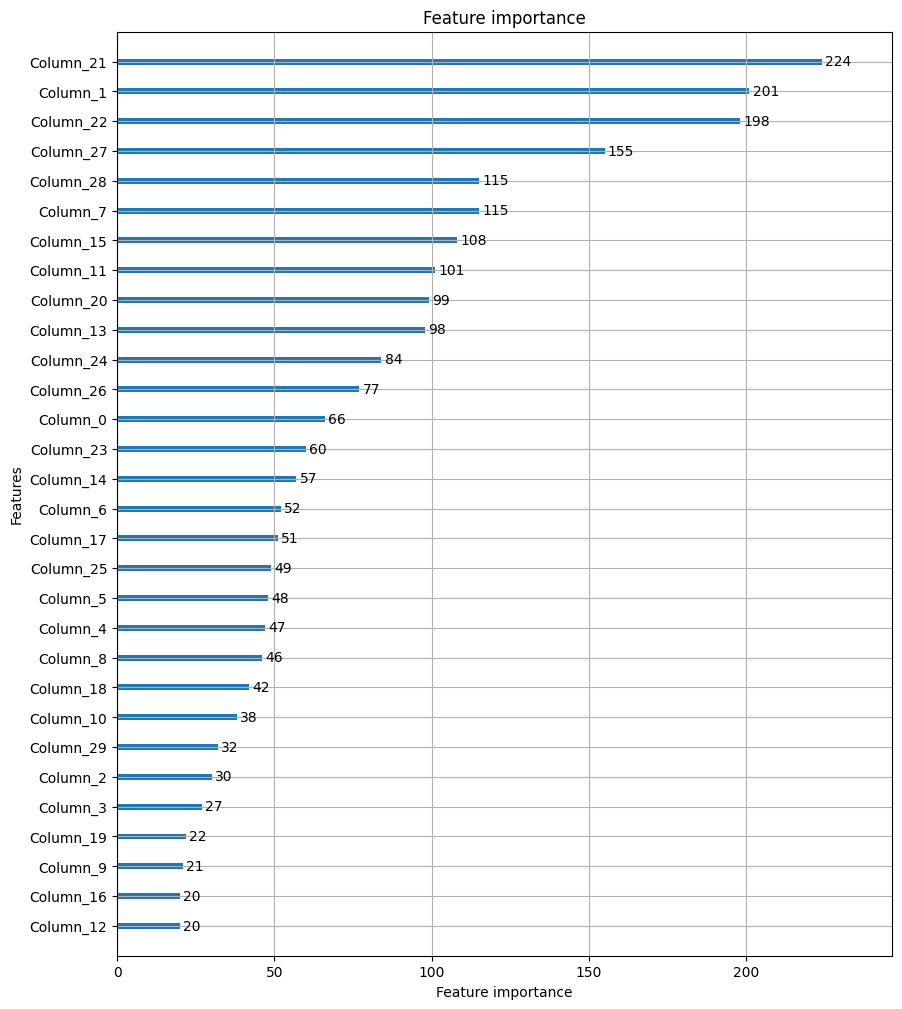

In [27]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)


## **08-11**

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/santander-customer-satisfaction/train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [29]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [30]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied : {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied : 0.04


In [31]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [32]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

X_features = cust_df.iloc[:,:-1]
y_labels = cust_df.iloc[:,-1]

print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('train set, shape:{0}, test set, shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

train set, shape:(60816, 369), test set, shape:(15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [34]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_clf = XGBClassifier(n_estimator=500, random_state=156)
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')

[23:19:04] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[0]	validation_0-auc:0.82005	validation_1-auc:0.81157
[1]	validation_0-auc:0.83400	validation_1-auc:0.82452
[2]	validation_0-auc:0.83870	validation_1-auc:0.82745
[3]	validation_0-auc:0.84419	validation_1-auc:0.82922
[4]	validation_0-auc:0.84783	validation_1-auc:0.83298
[5]	validation_0-auc:0.85125	validation_1-auc:0.83500
[6]	validation_0-auc:0.85501	validation_1-auc:0.83653
[7]	validation_0-auc:0.85831	validation_1-auc:0.83782
[8]	validation_0-auc:0.86143	validation_1-auc:0.83802
[9]	validation_0-auc:0.86452	validation_1-auc:0.83914
[10]	validation_0-auc:0.86717	validation_1-auc:0.83954
[11]	validation_0-auc:0.87013	validation_1-auc:0.83983
[12]	validation_0-auc:0.87369	validation_1-auc:0.84033
[13]	validation_0-auc:0.87620	validation_1-auc:0.84055
[14]	validation_0-auc:0.87799	validation_1-auc:0.84135
[15]	validation_0-auc:0.88071	validation_1-auc:0.84117
[16]	validation_0-auc:0.88237	validation_

In [35]:
from sklearn.model_selection import GridSearchCV

xgb_clf = XGBClassifier(n_estimators=100)

params = {
    'max_depth':[5,7],
    'min_child_weight':[1,3],
    'colsample_bytree':[0.5, 0.75]
    }

gridcv = GridSearchCV(xgb_clf, param_grid = params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])


print('최적 파라미터:', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:1], average='macro')
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.80289	validation_1-auc:0.80420
[1]	validation_0-auc:0.80677	validation_1-auc:0.80892
[2]	validation_0-auc:0.82161	validation_1-auc:0.81979
[3]	validation_0-auc:0.82877	validation_1-auc:0.82509
[4]	validation_0-auc:0.83227	validation_1-auc:0.82868
[5]	validation_0-auc:0.83179	validation_1-auc:0.82649
[6]	validation_0-auc:0.82662	validation_1-auc:0.81879
[7]	validation_0-auc:0.83687	validation_1-auc:0.82901
[8]	validation_0-auc:0.84136	validation_1-auc:0.83545
[9]	validation_0-auc:0.84304	validation_1-auc:0.83301
[10]	validation_0-auc:0.84221	validation_1-auc:0.83210
[11]	validation_0-auc:0.84723	validation_1-auc:0.83457
[12]	validation_0-auc:0.85187	validation_1-auc:0.83740
[13]	validation_0-auc:0.85373	validation_1-auc:0.83434
[14]	validation_0-auc:0.85631	validation_1-auc:0.83641
[15]	validation_0-auc:0.85719	validation_1-auc:0.83617
[16]	validation_0-auc:0.85906	validation_1-auc:0.83443
[17]	validation_0-auc:0.86100	validation_1-auc:0.83417
[18]	validation_0-au

ValueError: ignored

In [37]:
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7,
                        min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

xgb_clf.fit(X_train, y_train, early_stopping_rounds=200,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])


xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:1], average='macro')
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82311	validation_1-auc:0.81793
[1]	validation_0-auc:0.82585	validation_1-auc:0.81766
[2]	validation_0-auc:0.82950	validation_1-auc:0.81846
[3]	validation_0-auc:0.83162	validation_1-auc:0.82051
[4]	validation_0-auc:0.83561	validation_1-auc:0.82587
[5]	validation_0-auc:0.83569	validation_1-auc:0.82566
[6]	validation_0-auc:0.83635	validation_1-auc:0.82582
[7]	validation_0-auc:0.83757	validation_1-auc:0.82763
[8]	validation_0-auc:0.83873	validation_1-auc:0.82945
[9]	validation_0-auc:0.83986	validation_1-auc:0.83072
[10]	validation_0-auc:0.84036	validation_1-auc:0.83039
[11]	validation_0-auc:0.84071	validation_1-auc:0.83051
[12]	validation_0-auc:0.84064	validation_1-auc:0.82997
[13]	validation_0-auc:0.84098	validation_1-auc:0.82958
[14]	validation_0-auc:0.84174	validation_1-auc:0.83016
[15]	validation_0-auc:0.84223	validation_1-auc:0.83103
[16]	validation_0-auc:0.84262	validation_1-auc:0.83055
[17]	validation_0-auc:0.84302	validation_1-auc:0.83020
[18]	validation_0-au

ValueError: ignored

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

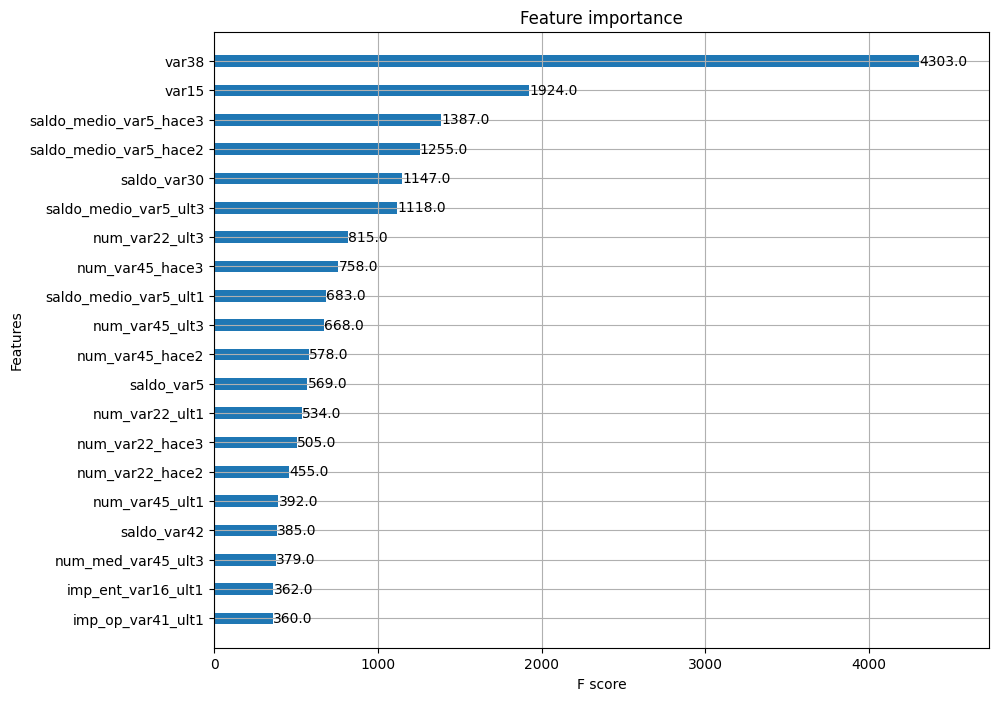

In [39]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

In [41]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
#lgbm_clf.fit(X_train, y_train, early_stopping_rounds=200,
#            eval_metric="auc", eval_set=evals)

lgbm_clf.fit(X_train, y_train)

xgb_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:1], average='macro')
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))


[LightGBM] [Info] Number of positive: 2374, number of negative: 58442
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.347188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14308
[LightGBM] [Info] Number of data points in the train set: 60816, number of used features: 251
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039036 -> initscore=-3.203459
[LightGBM] [Info] Start training from score -3.203459


ValueError: ignored

In [ ]:
from sklearn.model_selection import GriSearchCV

lgbm_clf = LGBMClassifier(n_estimators=200)

parms = {'num_leaves':[32, 64],
         'max_depth':[128, 160],
         'min_child_samples':[60, 100],
         'subsample':[0.8, 1]}

gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_round=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])


lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

In [42]:
lgbm_clf = LGBMClassifier(n_estimator=100, num_leaves=32, sumbsample=0.8, min_child_sample=100,
                          max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stooping_round=100, eval_metric="auc", eval_set=eval,
             verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

TypeError: ignored

In [ ]:
# conda install -c conda-forge imbalanced-learn

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [49]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time', axis=1, inplace=True)
  return df_copy

In [51]:

def get_train_test_dataset(df=None):
# Time열 드롭
  df_copy = get_preprocessed_df(df)

  X_features = df_copy.iloc[:, :-1]
  y_target = df_copy.iloc[:, -1]

  X_train, X_test, y_train, y_test = \
  train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [53]:
print(y_train.value_counts()/y_train.shape[0]*100)

print(y_test.value_counts()/y_test.shape[0]*100)

0    99.827451
1     0.172549
Name: Class, dtype: float64
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [55]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차행렬
[[85283    12]
 [   60    88]]
accuracy: 0.9992, precision:0.8800, recall: 0.5946, F1: 0.7097, AUC: 0.9593


In [58]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:, 1]
  get_clf_eval(tgt_test, pred, pred_proba)

In [59]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leavers=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

[LightGBM] [Warning] Unknown parameter: num_leavers
[LightGBM] [Warning] Unknown parameter: num_leavers
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

<Axes: xlabel='Amount', ylabel='Density'>

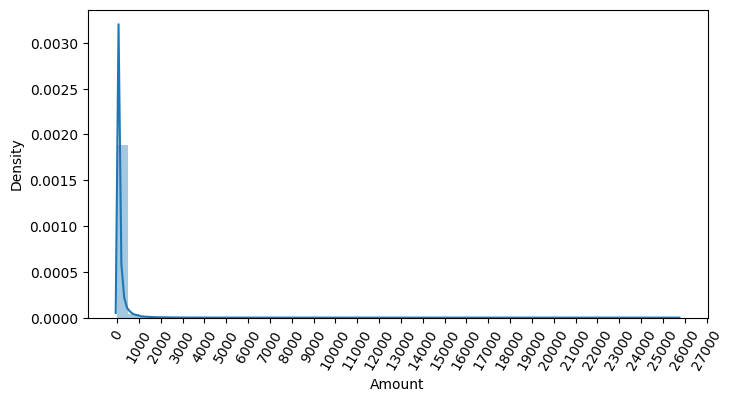

In [60]:
import seaborn as sns
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

In [63]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))

  df_copy.insert(0, 'Amount_Scaled', amount_n)

  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

In [64]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train,
                     tgt_test=y_test)

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차행렬
[[85281    14]
 [   58    90]]
accuracy: 0.9992, precision:0.8654, recall: 0.6081, F1: 0.7143, AUC: 0.9702
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001725 -> initscore=-6.360519
[LightGBM] [Info] Start training from score -6.360519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

In [65]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()

    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [66]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('###로지스틱 회귀 예측 성능###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train,
                     tgt_test=y_test)

print('###LightGBM 예측 성능###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train,
                     tgt_test=y_test)

###로지스틱 회귀 예측 성능###
오차행렬
[[85283    12]
 [   59    89]]
accuracy: 0.9992, precision:0.8812, recall: 0.6014, F1: 0.7149, AUC: 0.9727
###LightGBM 예측 성능###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.193998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001725 -> initscore=-6.360519
[LightGBM] [Info] Start training from score -6.360519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

<Axes: >

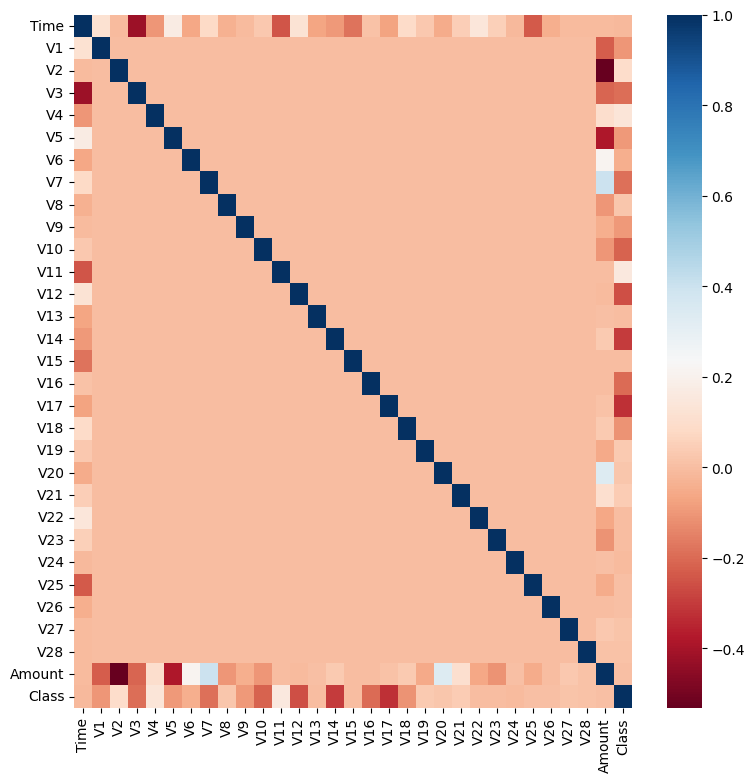

In [67]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr=card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [68]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
  fraud = df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)

  iqr = quantile_75 - quantile_25

  iqr_weight = iqr*weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight

  outlier_index = fraud[(fraud<lowest_val)|(fraud>highest_val)].index
  return outlier_index

In [69]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('outlier data index', outlier_index)

outlier data index Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [71]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)

  outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis = 0, inplace = True)

  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test = X_test, tgt_train = y_train,
                     tgt_test = y_test)

get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test = X_test, tgt_train = y_train,
                     tgt_test = y_test)

오차행렬
[[85281    14]
 [   48    98]]
accuracy: 0.9993, precision:0.8750, recall: 0.6712, F1: 0.7597, AUC: 0.9743
[LightGBM] [Info] Number of positive: 342, number of negative: 199020
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199362, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001715 -> initscore=-6.366350
[LightGBM] [Info] Start training from score -6.366350
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

In [76]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)

# fit_sample > fit_resample??
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape)
print(X_train_over.shape, y_train_over.shape)
print(pd.Series(y_train_over).value_counts())

(199362, 29) (199362,)
(398040, 29) (398040,)
0    199020
1    199020
Name: Class, dtype: int64


In [77]:
lr_clf = LogisticRegression()

get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test = X_test, tgt_train = y_train_over,
                     tgt_test = y_test)

오차행렬
[[82937  2358]
 [   11   135]]
accuracy: 0.9723, precision:0.0542, recall: 0.9247, F1: 0.1023, AUC: 0.9737


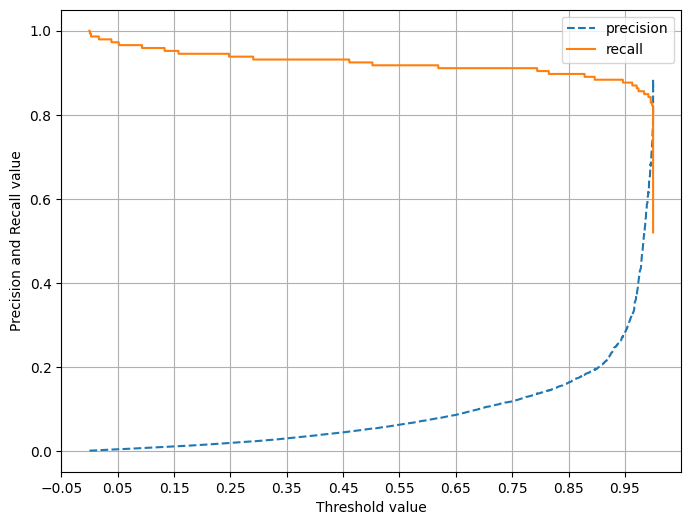

In [79]:
from ast import increment_lineno
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve


%matplotlib inline


def precision_recall_curve_plot(y_test, pred_proba_c1):
  # threshold ndarray와 이 임계점에 따른 정밀도, 재현율 ndarray 추출
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # X축을 threshold값으로, Y축은 정밀도,재현율 값으로 각각 plot수행. 정밀도는 점선
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  # threshold 값 X축의 Scale을 0.1단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))

  # x축, y축 label, legend, grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()


precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [ ]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [81]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                     tgt_train=y_train_over, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [82]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)


In [83]:
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state = 0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

lr_final = LogisticRegression(C=10)

knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print(accuracy_score(y_test, knn_pred))
print(accuracy_score(y_test, rf_pred))
print(accuracy_score(y_test, dt_pred))
print(accuracy_score(y_test, ada_pred))

0.9210526315789473
0.9649122807017544
0.9122807017543859
0.956140350877193


In [94]:
pred = np.array([knn_pred,rf_pred,dt_pred,ada_pred])

print(pred.shape)

pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [95]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print(accuracy_score(y_test, final))

0.9736842105263158


In [103]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  kf = KFold(n_splits=n_folds, shuffle=False)

  train_fold_pred = np.zeros((X_train_n.shape[0], 1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__)

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    print(folder_counter)
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    model.fit(X_tr, y_tr)
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
    test_pred[:,folder_counter] = model.predict(X_test_n)

  test_pred_mean = np.mean(test_pred, axis = 1).reshape(-1,1)

  return train_fold_pred, test_pred_mean

knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)

print('original train data:', X_train.shape,'original test data', X_test.shape)
print('Stacking train data:', Stack_final_X_train.shape,'Stacking test data', Stack_final_X_test.shape)



KNeighborsClassifier
0
1
2
3
4
5
6
RandomForestClassifier
0
1
2
3
4
5
6
DecisionTreeClassifier
0
1
2
3
4
5
6
AdaBoostClassifier
0
1
2
3
4
5
6
original train data: (455, 30) original test data (114, 30)
Stacking train data: (455, 4) Stacking test data (114, 4)


In [104]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print(accuracy_score(y_test, stack_final))

0.9736842105263158
